In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### 1. Create a straight line dataset using the linear regression formula (weight * X + bias).

- Set weight=0.3 and bias=0.9 there should be at least 100 datapoints total.
- Split the data into 80% training, 20% testing.
- Plot the training and testing data so it becomes visual.

In [2]:
weight = 0.3
bias = 0.9

datapoints = 100

# Generating random X values using a uniform distribution
# between 0 and 1 for X
X = torch.linspace(0, 10, datapoints).unsqueeze(dim=1)
y = weight * X + bias
print(X[:10], X.shape, y[:10], y.shape)
# Data for X and y is now set.

split = int(0.8*len(X)) # 80% split

X_train, y_train = X[:split], y[:split] # 80% for training
X_test, y_test = X[split:], y[split:] # 20% for testing

print(len(X_train), len(y_train), len(X_test), len(y_test))

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
X_train, X_test, y_train, y_test = (t.to(device) for t in (X_train, X_test, y_train, y_test))

tensor([[0.0000],
        [0.1010],
        [0.2020],
        [0.3030],
        [0.4040],
        [0.5051],
        [0.6061],
        [0.7071],
        [0.8081],
        [0.9091]]) torch.Size([100, 1]) tensor([[0.9000],
        [0.9303],
        [0.9606],
        [0.9909],
        [1.0212],
        [1.0515],
        [1.0818],
        [1.1121],
        [1.1424],
        [1.1727]]) torch.Size([100, 1])
80 80 20 20


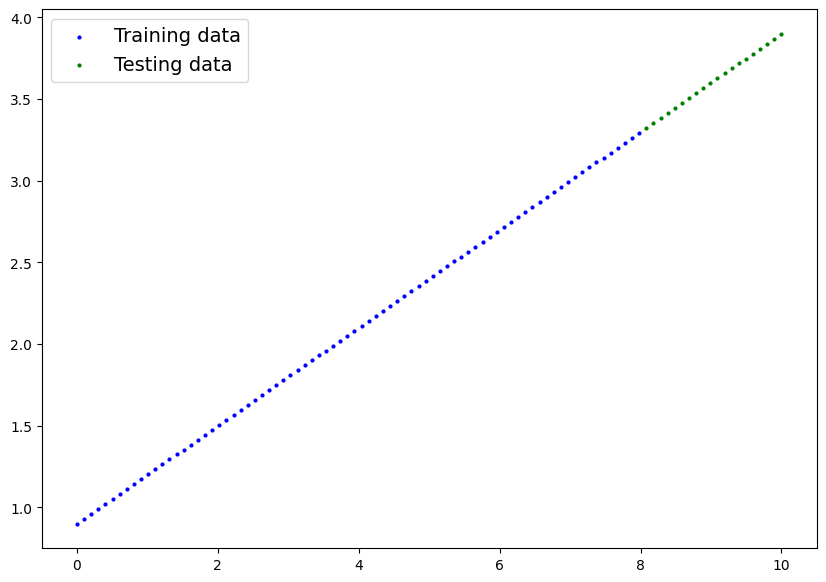

In [3]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Helper function to convert tensors to CPU and numpy
    def to_cpu_numpy(data):
        if isinstance(data, torch.Tensor):
            return data.cpu().numpy()
        return data

    # Convert all tensors to CPU and numpy
    train_data = to_cpu_numpy(train_data)
    train_labels = to_cpu_numpy(train_labels)
    test_data = to_cpu_numpy(test_data)
    test_labels = to_cpu_numpy(test_labels)
    
    if predictions is not None:
        predictions = to_cpu_numpy(predictions)

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    
    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

plot_predictions()

---

### 2. Build a PyTorch model by subclassing nn.Module.

- Inside should be a randomly initialized nn.Parameter() with requires_grad=True, one for weights and one for bias.
- Implement the forward() method to compute the linear regression function you used to create the dataset in 1.
- Once you've constructed the model, make an instance of it and check its state_dict().


In [4]:
# way 1
class SimpleLinearRegressionV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.weights = nn.Parameter(
            torch.randn(1, dtype=torch.float32),
            requires_grad=True
            )

        self.biases = nn.Parameter(
            torch.randn(1, dtype=torch.float32),
            requires_grad=True
            )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.biases

In [5]:
torch.manual_seed(741)

model_01 = SimpleLinearRegressionV1()
model_01.state_dict()

OrderedDict([('weights', tensor([0.3076])), ('biases', tensor([0.2766]))])

In [6]:
# way 2

class SimpleLinearRegressionV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(
            in_features=1,
            out_features=1,
            bias=True,
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [7]:
torch.manual_seed(741)

model_02 = SimpleLinearRegressionV2()
model_02.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.2209]])),
             ('linear_layer.bias', tensor([-0.7778]))])

---

### A quick detour

Let me take a quick detour to explain to myself what the significance is behind using `1` for `in_features` and `out_features` in `nn.Linear`. What do these numbers represent? 

Of course, I could simply wrap it up by stating to myself that it's the number of features in the input and the number of features in the output. But, I wanted to go a little further. What if the number wasn't 1? What if it wasn't a single number? What if it was a matrix?

I tried with multiple inputs and outputs.

Below, I consider a concrete example with:
- 3 input features
- 2 output features

The weight matrix W would have shape (3, 2) because:
- It needs to map 3 inputs to 2 outputs
- Each column represents the weights for one output feature

The bias vector b would have shape (2) because:
- There needs to be one bias term for each output feature

In [8]:
X_ex = torch.randn(3,3)
X_ex, X_ex.shape

(tensor([[ 1.3602,  0.7703, -2.0275],
         [-0.4813, -0.1112, -1.4053],
         [-0.1164,  0.0335, -0.6157]]),
 torch.Size([3, 3]))

In [9]:
W_ex = torch.randn(3,2)
W_ex, W_ex.shape

(tensor([[ 0.0942,  0.8087],
         [ 0.8294,  0.5845],
         [-0.1005,  0.7330]]),
 torch.Size([3, 2]))

In [10]:
b_ex = torch.randn(2)
b_ex, b_ex.shape

(tensor([-0.4016,  0.0796]), torch.Size([2]))

So, computation for this is:
$$y[i, j] = x[i, 0] * W[0, j] + x[i, 1] * W[1, j] + b[j]$$



In [11]:
y_ex = X_ex @ W_ex + b_ex
y_ex

tensor([[ 0.5691,  0.1436],
        [-0.3980, -1.4047],
        [-0.3229, -0.4463]])

A PyTorch model for this would be:

In [12]:
class MultiInputOutputModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(
            in_features=3, out_features=2, bias=True, dtype=torch.float32
            )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)

In [13]:
# creating an instance of this model
multi_model = MultiInputOutputModel()
multi_model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0133, -0.5068,  0.1708],
                      [-0.0020,  0.4990, -0.1469]])),
             ('linear.bias', tensor([0.4665, 0.3191]))])

Here, I can see that the `linear.weight` has shape (2, 3) (despite our intuition that it should be (3, 2)) and the `linear.bias` has shape (2).

This is because PyTorch's `nn.Linear` class always transposes the weight matrix to (out_features, in_features). It calls the weight matrix `W` and the input matrix `X` and computes `X @ W.T + b`. "Affine transformation" is the term used for this operation.

This is a bit counterintuitive, but it's a consequence of how PyTorch handles matrix multiplication.

**In summary:**

Case 1:
- a `nn.Linear` layer with `in_features=3` and `out_features=2` will have a weight matrix of shape (2, 3).
- the input matrix `X` will be multiplied by the weight matrix `W.T` (transposed) and then added to the bias vector `b`. So, the bias vector `b` will have shape (2).

Case 2:
- a `nn.Linear` layer with `in_features=5` and `out_features=12` will have a weight matrix of shape (12, 5).
- the input matrix `X` will be multiplied by the weight matrix `W.T` (transposed) and then added to the bias vector `b`. So, the bias vector `b` will have shape (12).


Of course, I can also set the weights and biases manually. 

Here, I set the weights and biases manually for the `multi_model` instance.

In [14]:
# setting specific weights and biases for demo
with torch.inference_mode():
    multi_model.linear.weight = nn.Parameter(torch.tensor([[0.1, 0.2],
                                                     [0.3, 0.4],
                                                     [0.5, 0.6]]))
    multi_model.linear.bias = nn.Parameter(torch.tensor([0.01, 0.02]))


In [15]:
multi_model.state_dict()

OrderedDict([('linear.weight',
              tensor([[0.1000, 0.2000],
                      [0.3000, 0.4000],
                      [0.5000, 0.6000]])),
             ('linear.bias', tensor([0.0100, 0.0200]))])

Here, I can see that the `linear.weight` has shape (3, 2) and the `linear.bias` has shape (2).

```python
OrderedDict([('linear.weight',
              tensor([[0.1000, 0.2000],
                      [0.3000, 0.4000],
                      [0.5000, 0.6000]])),
             ('linear.bias', tensor([0.0100, 0.0200]))]
```

Obviously, we don't really (and often it is not) set the weights and biases manually. We use the `nn.Linear` class to do that because we probably don't even know what the weights and biases are. We let the model learn them.


#### Detour over

---

---

### 3. Create a loss function and optimizer using `nn.L1Loss()` and `torch.optim.SGD(params, lr)` respectively.

- Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
- Write a training loop to perform the appropriate training steps for 300 epochs.
- The training loop should test the model on the test dataset every 20 epochs.


In [16]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_02.parameters(), lr=0.01)

In [17]:
# training loop

torch.manual_seed(741)

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
model_02, X_train, X_test, y_train, y_test = (t.to(device) for t in (model_02, X_train, X_test, y_train, y_test))

epochs = 300

train_loss_val = []
test_loss_val = []
epoch_count = []

for epoch in range(epochs):
    # +++++++++++++++++++++++++++ training mode
    model_02.train()

    # forward pass
    y_pred = model_02(X_train)

    # loss calc
    loss = loss_fn(y_pred, y_train)

    # zero grad
    optimizer.zero_grad()

    # backward
    loss.backward()

    # step
    optimizer.step()

    # ++++++++++++++++++++++++++ test mode
    model_02.eval()

    with torch.inference_mode():
        test_pred = model_02(X_test)
        test_loss = loss_fn(test_pred, y_test)
    
    if epoch % 20 == 0:
        print(f"""Epoch {epoch} | Train Loss: {loss} | Test Loss: {test_loss}
""")
        train_loss_val.append(loss)
        test_loss_val.append(test_loss)
        epoch_count.append(epoch)

Epoch 0 | Train Loss: 3.7559354305267334 | Test Loss: 6.015811920166016

Epoch 20 | Train Loss: 0.6255341172218323 | Test Loss: 0.7677910327911377

Epoch 40 | Train Loss: 0.5842267870903015 | Test Loss: 0.8357445001602173

Epoch 60 | Train Loss: 0.5503575205802917 | Test Loss: 0.7852458357810974

Epoch 80 | Train Loss: 0.516488254070282 | Test Loss: 0.734747052192688

Epoch 100 | Train Loss: 0.48264357447624207 | Test Loss: 0.6972829699516296

Epoch 120 | Train Loss: 0.4487926661968231 | Test Loss: 0.6467865109443665

Epoch 140 | Train Loss: 0.41492339968681335 | Test Loss: 0.5962911248207092

Epoch 160 | Train Loss: 0.38105419278144836 | Test Loss: 0.5457954406738281

Epoch 180 | Train Loss: 0.3471848964691162 | Test Loss: 0.4952998161315918

Epoch 200 | Train Loss: 0.3133157193660736 | Test Loss: 0.4448041021823883

Epoch 220 | Train Loss: 0.2794564366340637 | Test Loss: 0.40734273195266724

Epoch 240 | Train Loss: 0.2456190586090088 | Test Loss: 0.35684728622436523

Epoch 260 | Trai

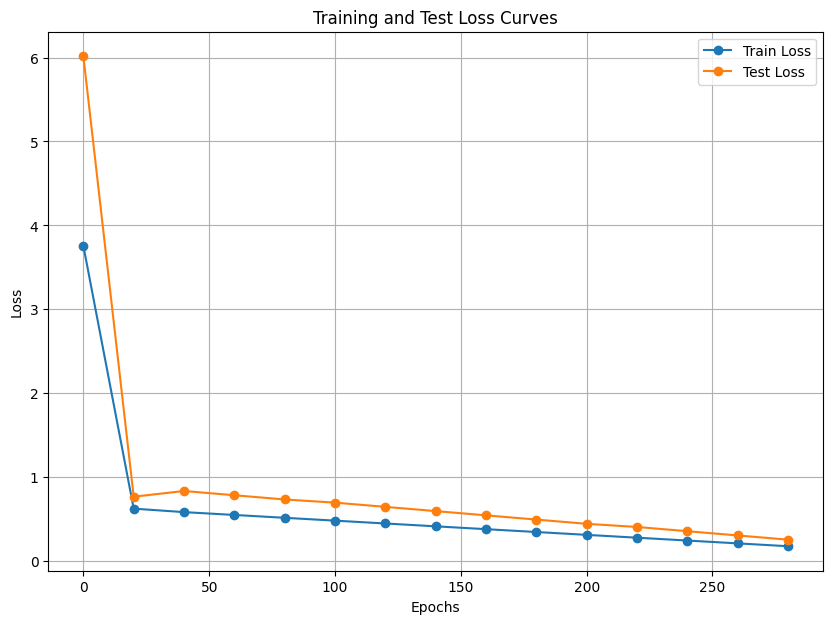

In [18]:
plt.figure(figsize=(10, 7))

# Convert tensors to numpy arrays if needed
train_loss_values = [loss.item() for loss in train_loss_val]
test_loss_values = [loss.item() for loss in test_loss_val]

plt.plot(epoch_count, train_loss_values, label="Train Loss", marker='o')
plt.plot(epoch_count, test_loss_values, label="Test Loss", marker='o')
plt.title("Training and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
print("The model learned the following values for weights and bias:")
print(model_02.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.3614]], device='mps:0')), ('linear_layer.bias', tensor([0.5555], device='mps:0'))])

And the original values for weights and bias are:
weights: 0.3, bias: 0.9


---

### 4. Make predictions with the trained model on the test data.

Visualize these predictions against the original training and testing data (note: you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).


In [20]:
model_02.eval()

if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model_02.to(device)

with torch.inference_mode():
    prediction = model_02(X_test)

prediction

tensor([[3.4758],
        [3.5123],
        [3.5488],
        [3.5853],
        [3.6218],
        [3.6583],
        [3.6948],
        [3.7314],
        [3.7679],
        [3.8044],
        [3.8409],
        [3.8774],
        [3.9139],
        [3.9504],
        [3.9869],
        [4.0234],
        [4.0599],
        [4.0964],
        [4.1329],
        [4.1694]], device='mps:0')

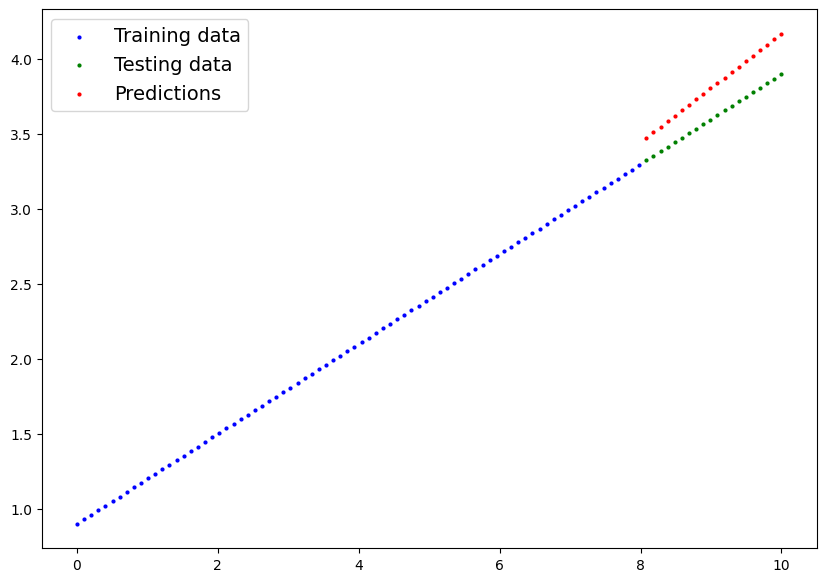

In [21]:
plot_predictions(predictions=prediction)

---

### 5. Save your trained model's state_dict() to file.

Create a new instance of your model class you made in 2. and load in the state_dict() you just saved to it.
Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [22]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "exercise_linear_regression_model.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

print(f"Saving this model to: {MODEL_SAVE_PATH}")
#saving only the dict
torch.save(obj=model_02.state_dict(), f=MODEL_SAVE_PATH)

Saving this model to: models/exercise_linear_regression_model.pth


### Loading the saved model to ensure it works

In [23]:
loaded_model_02 = SimpleLinearRegressionV2()

loaded_model_02.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_02.to(device)
print(f"Loaded model:\n{loaded_model_02}")
print(f"Model on device:\n{next(loaded_model_02.parameters()).device}")

Loaded model:
SimpleLinearRegressionV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
mps:0


/var/folders/27/84mpvnn15tlby6jt5y456k5c0000gn/T/ipykernel_95460/3636246623.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_02.load_state_dict(torch.load(f=

In [24]:
# Evaluate loaded model
loaded_model_02.eval()
with torch.inference_mode():
    loaded_model_02_preds = loaded_model_02(X_test)
prediction == loaded_model_02_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='mps:0')